# Forest Fire Prediction Project - Data Loading

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook handles the loading and initial processing of all datasets required for the forest fire prediction project:
- Land Cover (Algeria & Tunisia)
- Fire Occurrences (2024)
- Climate Data (Temperature, Precipitation)
- Elevation Data
- Soil Characteristics


In [1]:
## 1. Import Required Libraries

import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pyodbc

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 8)

## 2. Land Cover Dataset

Loading and combining land cover shapefiles for Algeria and Tunisia to create a unified study area mask.


Loading Algeria land cover...
✅ Algeria: 386454 features
Loading Tunisia land cover...
✅ Tunisia: 52059 features

✅ Combined Land Cover: 438513 features
CRS: EPSG:4326
✅ Saved to: ../data/raw/Land Cover/combined/combined_landcover.shp


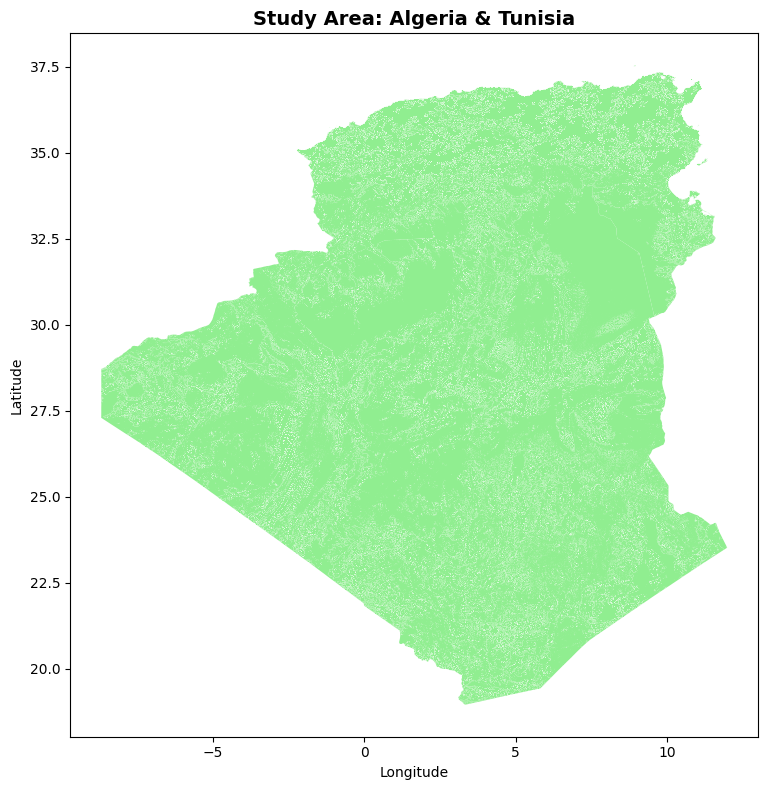


Dataset Overview:
   ID  GRIDCODE          AREA       LCCCODE  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  AREA_M2 LCCCode  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...      NaN     NaN  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...      NaN     NaN  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...      NaN     NaN  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...      NaN     NaN  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...      NaN     NaN  


In [2]:

def load_landcover_data():
    """Load and combine Algeria and Tunisia land cover shapefiles."""
    
    # Define paths
    landcover_path_dza = "../data/raw/Land Cover/geonetwork_landcover_DZA_gc_adg/dza_gc_adg.shp"
    landcover_path_tun = "../data/raw/Land Cover/geonetwork_landcover_tun_gc_adg/tun_gc_adg.shp"
    output_path = "../data/raw/Land Cover/combined/combined_landcover.shp"
    
    # Load individual shapefiles
    print("Loading Algeria land cover...")
    gdf_landcover_dza = gpd.read_file(landcover_path_dza)
    print(f"✅ Algeria: {gdf_landcover_dza.shape[0]} features")
    
    print("Loading Tunisia land cover...")
    gdf_landcover_tun = gpd.read_file(landcover_path_tun)
    print(f"✅ Tunisia: {gdf_landcover_tun.shape[0]} features")
    
    # Combine both datasets
    gdf_landcover = pd.concat([gdf_landcover_dza, gdf_landcover_tun], ignore_index=True)
    print(f"\n✅ Combined Land Cover: {gdf_landcover.shape[0]} features")
    print(f"CRS: {gdf_landcover.crs}")
    
    # Save combined shapefile
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    gdf_landcover.to_file(output_path)
    print(f"✅ Saved to: {output_path}")
    
    return gdf_landcover

# Load land cover data
gdf_mask = load_landcover_data()

# Visualize the study area
fig, ax = plt.subplots(figsize=(10, 8))
gdf_mask.plot(ax=ax, color='lightgreen')
ax.set_title("Study Area: Algeria & Tunisia", fontsize=14, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

# Display basic information
print("\nDataset Overview:")
print(gdf_mask.head())

## 3. Fire Dataset

Loading fire occurrence data from VIIRS NOAA-20 for Algeria and Tunisia (2024).


In [3]:
def load_fire_data():
    """Load and combine fire occurrence data for Algeria and Tunisia."""
    
    fire_data_path = "../data/raw/Fire"
    output_path = "../data/processed/Fire/combined_fire_data_2024.csv"
    
    # List all CSV files
    csv_files = [f for f in os.listdir(fire_data_path) if f.endswith('.csv')]
    
    # Load each file
    fire_datasets = {}
    for file in csv_files:
        country_name = file.replace('_fire_2024.csv', '').capitalize()
        file_path = os.path.join(fire_data_path, file)
        df = pd.read_csv(file_path)
        fire_datasets[country_name] = df
        print(f"✅ Loaded {country_name}: {df.shape[0]} fire events")
    
    # Combine all datasets
    fire_data_combined = pd.concat(fire_datasets.values(), ignore_index=True)
    print(f"\n✅ Combined Fire Data: {fire_data_combined.shape[0]} total events")
    
    # Save combined dataset
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    fire_data_combined.to_csv(output_path, index=False)
    print(f"✅ Saved to: {output_path}")
    
    return fire_data_combined

# Load fire data
df_fires = load_fire_data()

# Display summary statistics
print("\nFire Data Summary:")
print(df_fires.describe())
print("\nColumns:", df_fires.columns.tolist())


✅ Loaded Algeria: 87446 fire events
✅ Loaded Tunisia: 2804 fire events

✅ Combined Fire Data: 90250 total events
✅ Saved to: ../data/processed/Fire/combined_fire_data_2024.csv

Fire Data Summary:
           latitude     longitude    bright_ti4          scan         track  \
count  90250.000000  90250.000000  90250.000000  90250.000000  90250.000000   
mean      31.476760      6.280033    321.091793      0.475991      0.515446   
std        2.666477      2.593748     18.205551      0.101596      0.126508   
min       19.603230     -8.118050    240.170000      0.320000      0.360000   
25%       28.911510      5.642160    305.380000      0.400000      0.390000   
50%       31.409125      6.557880    316.710000      0.450000      0.490000   
75%       32.560313      8.083758    337.400000      0.540000      0.620000   
max       37.323460     11.110350    367.000000      0.800000      0.780000   

           acq_time  version    bright_ti5           frp          type  
count  90250.000000

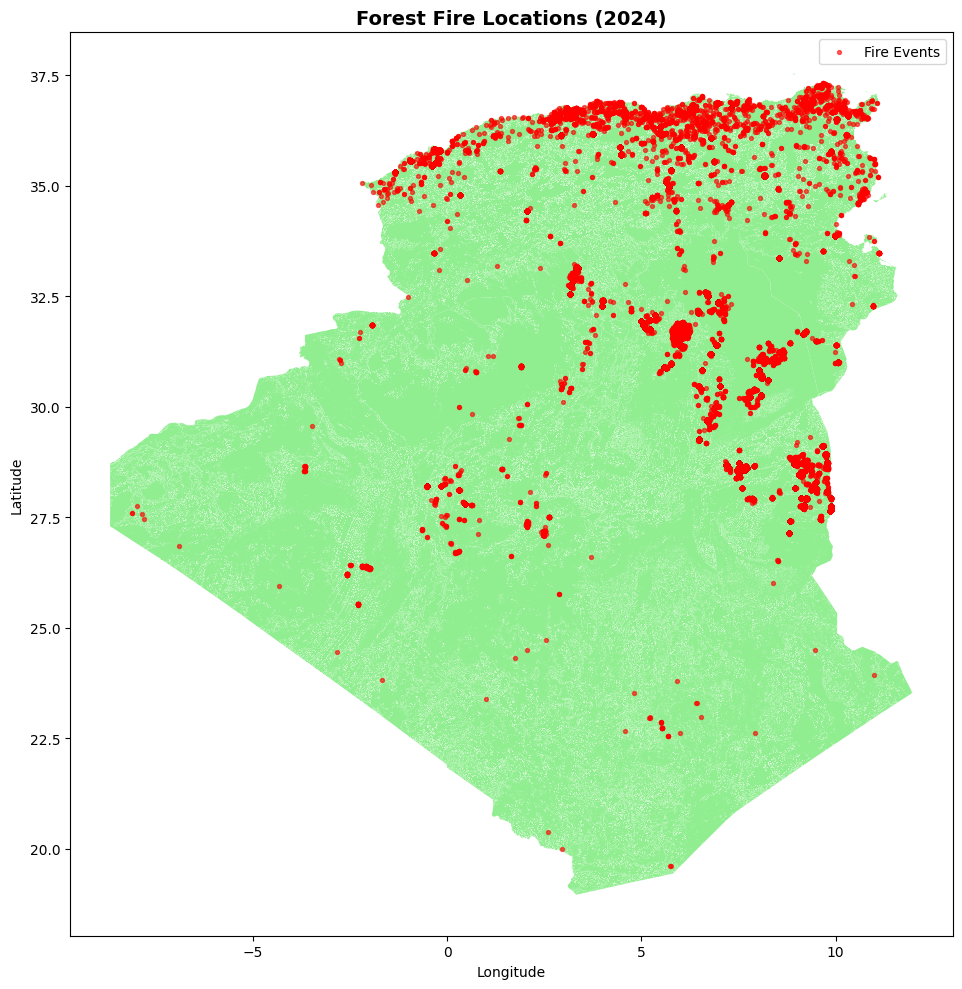

Total fire events plotted: 90250


In [4]:

### 3.1 Visualize Fire Locations

def plot_fires_on_map(fires_csv, shapefile_gdf):
    """Plot fire locations on the study area map."""
    
    # Load fire data
    df = pd.read_csv(fires_csv)
    
    # Convert to GeoDataFrame
    gdf_fires = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )
    
    # Reproject to match shapefile CRS
    if gdf_fires.crs != shapefile_gdf.crs:
        gdf_fires = gdf_fires.to_crs(shapefile_gdf.crs)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    shapefile_gdf.plot(ax=ax, color='lightgreen')
    gdf_fires.plot(ax=ax, color='red', markersize=8, alpha=0.6, label='Fire Events')
    
    ax.set_title("Forest Fire Locations (2024)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Total fire events plotted: {len(gdf_fires)}")

# Visualize fires
fires_csv = "../data/processed/Fire/combined_fire_data_2024.csv"
plot_fires_on_map(fires_csv, gdf_mask)



## 4. Climate Dataset

Loading and clipping climate rasters (temperature and precipitation) to the study area.


In [5]:

def process_climate_data(gdf_mask, year=2024):
    """Process and clip climate data to study area."""
    
    climate_base_path = "../data/raw/Climate"
    climate_output_path = "../data/processed/Climate"
    os.makedirs(climate_output_path, exist_ok=True)
    
    # Define variables to process
    variables = {
        "tmax": "wc2.1_cruts4.09_5m_tmax_2020-2024",
        "tmin": "wc2.1_cruts4.09_5m_tmin_2020-2024",
        "prec": "wc2.1_cruts4.09_5m_prec_2020-2024"
    }
    
    processed_files = []
    
    for var_name, var_dir in variables.items():
        print(f"\nProcessing {var_name.upper()}...")
        var_path = os.path.join(climate_base_path, var_dir)
        
        if not os.path.exists(var_path):
            print(f"⚠️  Directory not found: {var_path}")
            continue
        
        tif_files = [f for f in os.listdir(var_path) 
                     if f.endswith('.tif') and str(year) in f]
        
        for tif_file in tif_files:
            input_tif = os.path.join(var_path, tif_file)
            output_tif = os.path.join(climate_output_path, 
                                     tif_file.replace(".tif", "_clipped.tif"))
            
            # Clip raster to study area
            with rasterio.open(input_tif) as src:
                out_image, out_transform = mask(src, gdf_mask.geometry, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
            
            with rasterio.open(output_tif, "w", **out_meta) as dest:
                dest.write(out_image)
            
            processed_files.append(output_tif)
            print(f"✅ Clipped: {os.path.basename(output_tif)}")
    
    return processed_files

# Process climate data
climate_files = process_climate_data(gdf_mask, year=2024)
print(f"\n✅ Total climate files processed: {len(climate_files)}")



Processing TMAX...
✅ Clipped: wc2.1_cruts4.09_5m_tmax_2024-01_clipped.tif


KeyboardInterrupt: 

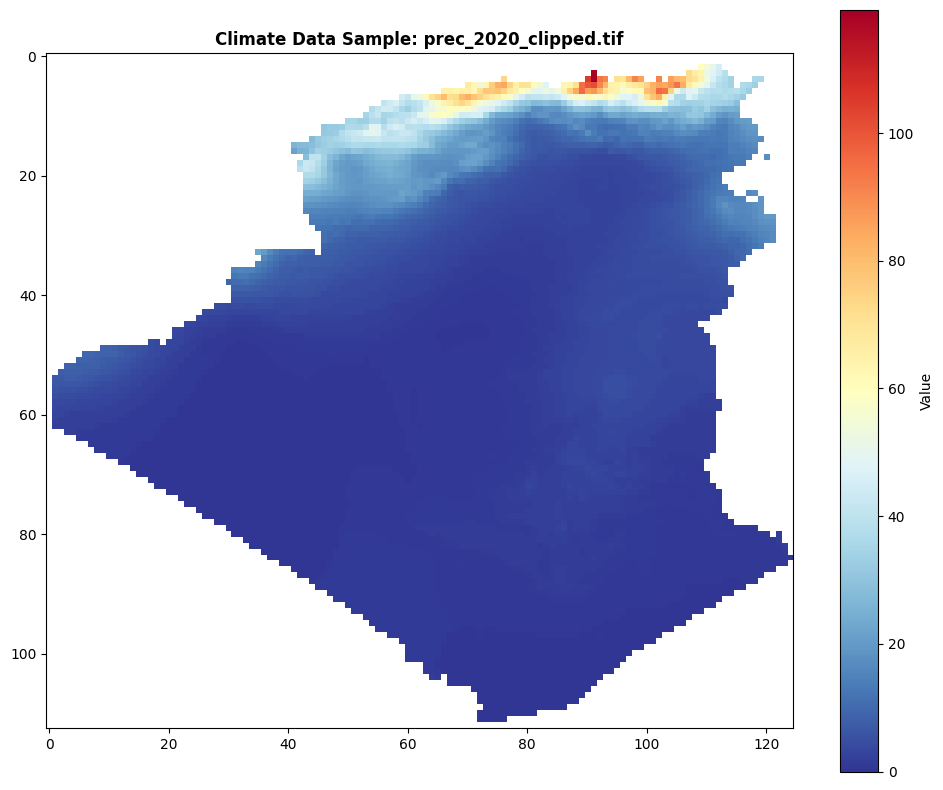

In [7]:
### 4.1 Visualize Sample Climate Data

# Display a sample clipped climate file
climate_sample_path = "../data/processed/Climate"
sample_files = [f for f in os.listdir(climate_sample_path) if f.endswith('_clipped.tif')]

if sample_files:
    sample_file = os.path.join(climate_sample_path, sample_files[0])
    
    with rasterio.open(sample_file) as src:
        data = src.read(1)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(data, cmap='RdYlBu_r')
        ax.set_title(f"Climate Data Sample: {os.path.basename(sample_file)}", 
                    fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='Value')
        plt.tight_layout()
        plt.show()


## 5. Elevation Dataset

Loading and clipping elevation data to the study area.


In [9]:

def process_elevation_data(gdf_mask):
    """Process and clip elevation raster to study area."""
    
    elev_input = "../data/raw/Elevation/be15_grd/be15_grd"
    elev_output = "../data/processed/Elevation/elevation_clipped.tif"
    
    print("Processing elevation data...")
    
    # Create output directory
    os.makedirs(os.path.dirname(elev_output), exist_ok=True)
    
    # Clip elevation raster
    with rasterio.open(elev_input) as src:
        print(f"Input CRS: {src.crs}")
        print(f"Input shape: {src.height} x {src.width}")
        
        out_image, out_transform = mask(src, gdf_mask.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    
    with rasterio.open(elev_output, "w", **out_meta) as dest:
        dest.write(out_image)
    
    print(f"✅ Clipped elevation saved: {elev_output}")
    return elev_output

# Process elevation
elev_file = process_elevation_data(gdf_mask)

Processing elevation data...
Input CRS: EPSG:4326
Input shape: 33600 x 86400
✅ Clipped elevation saved: ../data/processed/Elevation/elevation_clipped.tif


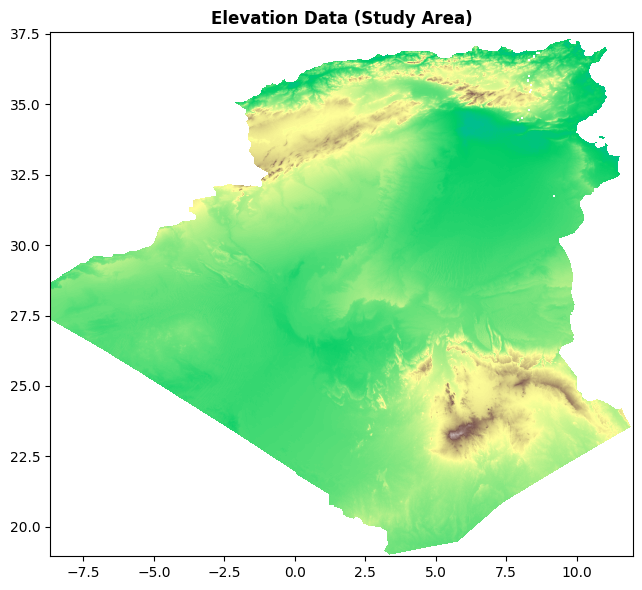

In [14]:
# Visualize elevation
with rasterio.open(elev_file) as src:
    fig, ax = plt.subplots(figsize=(10, 6))
    show(src, ax=ax, cmap='terrain', title="Elevation Data (Study Area)")
    plt.tight_layout()
    plt.show()

## 6. Soil Dataset

Loading soil characteristics from HWSD2 database and raster data.


In [15]:
# 6.1 Extract Soil Attributes from Database

def load_soil_attributes():
    """Load and filter soil attributes from HWSD2 database."""
    
    mdb_path = "../data/raw/Soil/HWSD2_DB/HWSD2.mdb"
    output_path = "../data/processed/Soil/soil_data_layers_filtered.csv"
    
    print("Connecting to HWSD2 database...")
    
    # Connect to Access database
    conn_str = f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={mdb_path};"
    conn = pyodbc.connect(conn_str)
    
    # Load soil layers
    df_soil = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
    conn.close()
    
    print(f"✅ Loaded soil data: {df_soil.shape[0]} rows")
    
    # Filter for top 20cm depth (D1 layer)
    df_soil = df_soil[df_soil['LAYER'] == 'D1']
    print(f"✅ Filtered to D1 layer: {df_soil.shape[0]} rows")
    
    # Select required features
    features = [
        "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
        "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
        "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
        "TCARBON_EQ", "GYPSUM", "ELEC_COND", "ID"
    ]
    
    df_soil_filtered = df_soil[features]
    
    # Save filtered data
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_soil_filtered.to_csv(output_path, index=False)
    
    print(f"✅ Saved filtered soil attributes: {output_path}")
    print(f"\nFeatures: {len(features)-1}")
    print(df_soil_filtered.head())
    
    return df_soil_filtered

# Load soil attributes
df_soil = load_soil_attributes()


Connecting to HWSD2 database...
✅ Loaded soil data: 408835 rows
✅ Filtered to D1 layer: 58405 rows
✅ Saved filtered soil attributes: ../data/processed/Soil/soil_data_layers_filtered.csv

Features: 22
     COARSE  SAND  SILT  CLAY  TEXTURE_USDA TEXTURE_SOTER  BULK  REF_BULK  \
666       5    67    18    15          11.0             C  1.35      1.63   
667       5    67    18    15          11.0             C  1.35      1.63   
668       5    67    18    15          11.0             C  1.35      1.63   
669       5    67    18    15          11.0             C  1.35      1.63   
694       2    24    52    24           7.0             M  1.44      1.76   

     ORG_CARBON  PH_WATER  TOTAL_N  CN_RATIO  CEC_SOIL  CEC_CLAY  CEC_EFF  \
666       1.062       6.3     0.77      13.0         8        46      6.0   
667       1.062       6.3     0.77      13.0         8        46      6.0   
668       1.062       6.3     0.77      13.0         8        46      6.0   
669       1.062       6.3    

In [16]:

# 6.2 Process Soil Raster Data

def process_soil_raster(gdf_mask):
    """Clip soil raster to study area."""
    
    soil_raster_path = "../data/raw/Soil/HWSD2_RASTER/HWSD2.bil"
    output_path = "../data/processed/Soil/soil_clipped_raster.tif"
    
    print("Processing soil raster...")
    
    # Open and clip raster
    with rasterio.open(soil_raster_path) as src:
        print(f"Input CRS: {src.crs}")
        print(f"Input shape: {src.height} x {src.width}")
        
        out_image, out_transform = mask(src, gdf_mask.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    
    # Save clipped raster
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)
    
    print(f"✅ Clipped soil raster saved: {output_path}")
    
    # Get unique soil IDs in study area
    unique_ids = np.unique(out_image)
    print(f"✅ Unique soil types in study area: {len(unique_ids)}")
    
    return output_path, unique_ids

# Process soil raster
soil_raster_file, soil_unique_ids = process_soil_raster(gdf_mask)

Processing soil raster...
Input CRS: OGC:CRS84
Input shape: 21600 x 43200
✅ Clipped soil raster saved: ../data/processed/Soil/soil_clipped_raster.tif
✅ Unique soil types in study area: 387


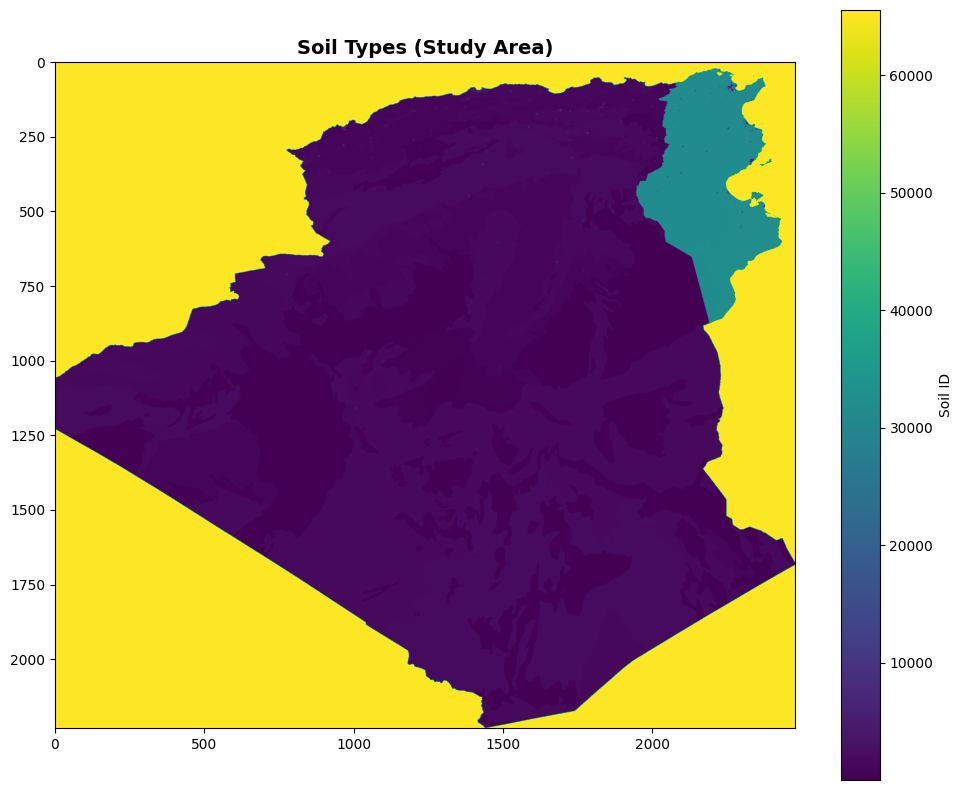

In [17]:

# Visualize soil raster
with rasterio.open(soil_raster_file) as src:
    data = src.read(1)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(data, cmap='viridis')
    ax.set_title("Soil Types (Study Area)", fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Soil ID')
    plt.tight_layout()
    plt.show()


## 7. Data Loading Summary


In [ ]:


print("="*70)
print("DATA LOADING COMPLETE")
print("="*70)

print("\n📊 Datasets Loaded:")
print(f"  ✅ Land Cover: {gdf_mask.shape[0]} features")
print(f"  ✅ Fire Events: {len(df_fires)} occurrences")
print(f"  ✅ Climate Files: {len(climate_files)} rasters")
print(f"  ✅ Elevation: Processed")
print(f"  ✅ Soil Attributes: {len(df_soil)} records")
print(f"  ✅ Soil Raster: {len(soil_unique_ids)} unique types")

print("\n📁 Output Directories:")
print("  • ../data/processed/Fire/")
print("  • ../data/processed/Climate/")
print("  • ../data/processed/Elevation/")
print("  • ../data/processed/Soil/")

print("="*70)
